# Create fake data for Regression Tasks

In this blog I'd like to show the difference deep tabular augmentation can have when training a Random Forest on a highly biased data base. In this case, we have a look at credit card fraud, where fraud itself is is way less represented than non-fraud. 

In [30]:
! pip install deep_tabular_augmentation

Processing /home/lasse/.cache/pip/wheels/62/94/4f/4b5ea796aba5503a4f879e3e3f734814650f281d49d1a8dca2/deep_tabular_augmentation-0.5.2-py3-none-any.whl


In [31]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = '../data/creditcard.csv'

df = pd.read_csv(DATA_PATH)

Let's have a short look at the data:

In [33]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This is a different idea: we want to make a regression task afterwards on "Amount", so let's get rid of "Class" and we want to also create fake data for the Amount. Moreover, we only want to create fake data for the Class 1, so only for Fraud cases. The idea is, that we only have few data so we want to create some more data to make our later on regression task more easy to train.

In [34]:
df_ = df[df['Class']==1]
df_ = df_.drop(['Class'], axis=1)

In [35]:
X_train, X_test = train_test_split(df_, test_size=0.1, random_state=42)

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

For our model to work we need to put our data in a DataLoader (here I use the DataBunch Class from deep data augmentation).

In [36]:
pd.DataFrame(X_train_scaled, columns=list(df_.columns))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1.680442,0.631506,0.275972,-0.100045,1.087832,0.635364,-0.710439,0.358548,0.091132,-0.796509,...,0.323165,0.001455,-0.330461,-0.030901,-1.244261,-0.447196,0.943652,0.479472,0.534000,-0.466166
1,-0.990864,0.746946,-0.443525,0.616781,-0.306660,0.471168,0.372418,0.438428,0.048051,0.215305,...,-0.048775,-0.038247,-0.132884,-0.170911,-1.296183,0.989907,0.361699,0.286957,0.413336,-0.398036
2,1.545065,0.449641,-1.687700,0.054589,-0.444148,0.271324,0.043154,0.792383,-0.061979,0.734876,...,2.067332,0.149110,-0.687050,-0.875470,-1.014906,-0.272854,0.726856,0.003546,0.724083,5.167617
3,-1.360664,0.863007,-0.635715,1.052134,-0.470653,0.618849,0.607618,0.749421,-0.056192,1.368728,...,-0.453275,-0.269928,-0.575049,0.072419,0.516769,0.402767,-0.374419,-0.096132,-0.039739,-0.454855
4,1.572111,0.535762,-0.106143,0.207448,-0.491548,0.412514,-0.629350,0.466374,0.042671,-0.170531,...,0.487684,0.040839,0.109069,-0.088643,-0.356966,0.586584,1.430899,0.375290,0.470332,-0.113905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,-0.863097,0.011975,-0.854733,0.248596,0.836226,1.607554,-1.607631,0.394880,-0.002476,-0.515204,...,-0.372366,-0.095676,-0.069049,-0.114344,-0.583561,1.051830,1.280207,0.245347,1.615121,-0.465305
438,0.072203,0.475678,-1.043646,1.158182,-1.433275,0.530149,0.698321,0.935677,-0.024806,0.809620,...,0.176776,-0.075522,-0.026221,0.544404,0.414935,0.154123,-1.435840,-0.191040,-0.073392,0.858081
439,0.451329,-0.157959,0.510532,-0.428063,1.345550,-0.271261,-0.090494,-0.199909,0.515282,-0.514859,...,-0.340383,0.132838,0.118239,0.200755,-0.844808,-0.181081,0.770482,-0.317209,-1.844034,-0.020568
440,1.457316,0.364980,-0.326484,0.495405,-1.526848,0.551114,0.886308,0.364821,-0.461626,0.805727,...,0.101278,-0.179009,0.342533,-0.021475,-0.653938,0.407461,-1.227798,-0.002493,-0.089635,-0.281777


In [18]:
df_.shape

(492, 30)

In [37]:
datasets = dta.create_datasets_no_target_var(X_train_scaled, X_test_scaled)
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024, device='cpu'))

TypeError: create_loaders() got an unexpected keyword argument 'device'

Now we're already good to go. We can define our Variational Encoder Architecture (here: 50->12->12->5->12->12->50) and then use the LearningRate Finder to tell us the best Learning rate:

In [10]:
D_in = X_train_scaled.shape[1]
VAE_arch = [50, 12, 12]
df_cols = list(df_.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [11]:
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)

In [12]:
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

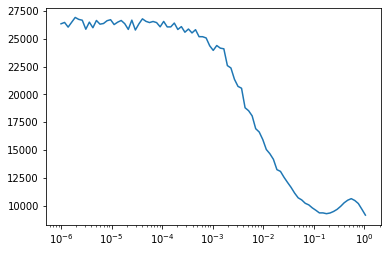

In [13]:
run.recorder.plot(skip_last=5)

We set up a desirable learning rate and scheduler for our learning rate:

In [14]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

Now, let's train the model:

In [15]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, cols=df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 27912.4296875
validation loss is: 1566.9921875
epoch: 100
train loss is: 11564.2529296875
validation loss is: 2035.2548828125
epoch: 150
train loss is: 9274.70703125
validation loss is: 1606.89404296875
epoch: 200
train loss is: 8181.79638671875
validation loss is: 1568.33642578125
epoch: 250
train loss is: 7496.8935546875
validation loss is: 1349.8231201171875
epoch: 300
train loss is: 7026.00390625
validation loss is: 1192.9500732421875
epoch: 350
train loss is: 6679.10498046875
validation loss is: 1085.3543701171875
epoch: 400
train loss is: 6414.5810546875
validation loss is: 1005.938720703125


Let's see how the created data looks like:

In [16]:
new_data_points = 1000
df_fake = run.predict_df(learn, no_samples=new_data_points, scaler=x_scaler)
std_list = list(df[df['Class']==1][df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=new_data_points, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,131824.427845,-1.427666,1.839570,-5.631380,3.887929,0.791883,-1.553439,-4.212977,0.167754,-2.439215,...,0.619956,1.559670,-0.501024,0.006788,-0.218253,0.159667,0.197105,0.332824,0.195289,30.874629
1,132657.293599,-1.860188,1.625119,-5.267459,3.216995,0.804744,-1.571403,-2.825599,-0.315328,-1.776208,...,0.299827,0.959283,0.148615,0.037241,-0.159773,0.232929,0.129729,-0.077984,0.162102,63.224206
2,132683.050724,-1.673027,2.190487,-3.775181,4.158269,-0.034269,-1.492201,-2.789129,-0.636187,-2.328790,...,0.452918,0.680613,-0.113098,0.087560,-0.258075,0.011004,0.185262,0.319291,0.091901,5.639199
3,122629.211185,-1.813942,2.940274,-3.557400,3.551654,0.194836,-1.328441,-3.374468,0.139292,-1.997304,...,0.379734,0.416199,0.449866,0.117698,-0.050494,0.169105,0.233085,0.452301,0.131720,46.059847
4,67218.911294,-3.501655,1.739513,-4.306705,3.367581,-2.119609,-1.162426,-3.754554,-0.499639,-1.587015,...,0.186405,1.029592,0.323766,-0.206371,0.165556,-0.281376,0.085867,0.039732,0.224321,75.235664


In [17]:
df_fake_with_noise.describe().loc[['mean']]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
mean,111363.124395,-2.050912,2.503201,-4.485389,3.683006,-1.021555,-1.384889,-3.080166,0.409571,-1.937855,...,0.311988,0.846723,0.031453,0.021025,-0.135667,0.002297,0.18831,0.151091,0.247337,58.809741


In [18]:
df_fake.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,112579.296875,-2.041498,2.518830,-4.506187,3.712905,-0.982648,-1.386780,-3.120601,0.401108,-1.966592,...,0.322694,0.834672,0.025249,0.033498,-0.144751,0.007743,0.192354,0.150840,0.251752,59.212181
std,18819.937500,0.523715,0.569610,1.022278,0.857565,0.628672,0.241379,0.704193,0.650714,0.395354,...,0.160215,0.351312,0.168661,0.147154,0.165362,0.117384,0.061709,0.112653,0.091702,8.857514
min,46319.476562,-13.639866,0.984600,-14.225799,1.923263,-9.023107,-2.151811,-20.841196,-14.666291,-7.690640,...,0.065304,-8.363460,-0.357641,-0.199369,-0.602742,-0.668905,-0.110069,-2.291188,-0.263182,17.294466
25%,99956.150391,-2.123040,2.101999,-5.178868,2.993815,-1.304872,-1.534795,-3.291496,0.043537,-2.214949,...,0.291557,0.691859,-0.066436,-0.109687,-0.261087,-0.053568,0.163472,0.093493,0.179895,55.760010
50%,113935.718750,-1.949954,2.494319,-4.451565,3.621030,-0.962698,-1.363867,-2.993327,0.384233,-1.980549,...,0.335520,0.852036,0.019045,0.050246,-0.103729,0.036781,0.206001,0.177674,0.254885,61.826450
75%,128356.363281,-1.878548,2.880398,-3.720749,4.258039,-0.590058,-1.229726,-2.833986,0.708341,-1.699640,...,0.359096,1.027184,0.124323,0.140917,-0.014325,0.094830,0.231034,0.205835,0.324618,64.784227
max,145322.578125,-1.053985,11.585474,-1.757935,8.756217,0.663065,1.524621,-1.864322,2.300719,-0.822219,...,5.070251,1.207049,3.350145,2.460644,0.173407,0.191943,0.399917,0.298374,0.430508,91.302277


In [19]:
df_fake_with_noise.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,111363.124395,-2.050912,2.503201,-4.485389,3.683006,-1.021555,-1.384889,-3.080166,0.409571,-1.937855,...,0.311988,0.846723,0.031453,0.021025,-0.135667,0.002297,0.188310,0.151091,0.247337,58.809741
std,20353.576080,0.828061,0.660078,1.220314,0.915277,0.829732,0.294232,0.869494,0.811907,0.440785,...,0.141839,0.443526,0.197757,0.201668,0.174513,0.144069,0.084452,0.166374,0.107218,27.507253
min,41579.317972,-5.548245,0.793419,-8.932817,1.830444,-4.290933,-2.350756,-7.077561,-1.861852,-3.738249,...,-0.221786,-0.481846,-0.571908,-0.666355,-0.694988,-0.548791,-0.125981,-0.364427,-0.399969,-31.133200
25%,99327.154067,-2.619332,2.031030,-5.264974,2.973670,-1.540757,-1.571783,-3.645245,-0.158624,-2.228723,...,0.220204,0.553826,-0.097286,-0.126796,-0.251567,-0.074155,0.138715,0.039950,0.171727,39.577258
50%,113344.684397,-2.033154,2.500318,-4.475448,3.561008,-0.981344,-1.365644,-3.052138,0.381989,-1.931890,...,0.313401,0.853186,0.046160,0.015761,-0.106069,0.021164,0.197106,0.153948,0.248209,60.342383
75%,127119.861118,-1.485297,2.972763,-3.616217,4.212322,-0.467096,-1.184726,-2.524289,0.948818,-1.626834,...,0.410359,1.151156,0.165139,0.158189,-0.001394,0.102369,0.244261,0.265813,0.324841,77.120488
max,152476.075783,0.404203,4.722312,-1.415840,7.372294,1.261773,-0.512975,-0.236469,2.980154,-0.408823,...,0.706200,2.241755,0.580044,0.713895,0.226148,0.365238,0.460573,0.643218,0.528996,131.339210


In [20]:
df[df['Class']==1].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0
